In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import os
import datetime
from itertools import islice
from datetime import date
import time

In [1]:
#!pip install ibm-cos-sdk

  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.8.0-py2.py3-none-any.whl size=72709 sha256=84a35fec4e7675d0503f4b8471eca8f80872541128d2998c530aa16f4a1e409f
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\46\0b\0e\4821e0423421be7ec772bca6772a0d94662297443220a4b0f0
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.8.0-py2.py3-none-any.whl size=501194 sha256=e64ce98727b70cadea558ae1d0a5f3579753f74c979b65f9f1aad0663bed31fb
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\31\01\09\a412f524c7aea90c970ec0cd821ec4adbb67cf5ce7b638b038
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos_sdk_s3transfer-2.8.0-py2.py3-none-any.whl size=88607 sha256=9ecbe04324f903e6b158f954525f4ea1c2926ae58d8744129e68b9451cc45091
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\ce\c3\53\2955ec0a59d932bcfcd6a1485aa4be964341687dd5ef4f18cb
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3transfer


In [ ]:
# original site seems to be permantly offline, using cached data
#!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/97.mat
#!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/98.mat
#!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/99.mat
#!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/100.mat
#!wget https://github.com/IBM/skillsnetwork/raw/master/coursera_ai/week3/data/cwr_healthy/97.mat
#!wget https://github.com/IBM/skillsnetwork/raw/master/coursera_ai/week3/data/cwr_healthy/98.mat
#!wget https://github.com/IBM/skillsnetwork/raw/master/coursera_ai/week3/data/cwr_healthy/99.mat
#!wget https://github.com/IBM/skillsnetwork/raw/master/coursera_ai/week3/data/cwr_healthy/100.mat


In [ ]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_d3bd5b94a9334de59a55a7fed2bedeaa(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_adcb54bd899a7e39e31582bccad1577f68f1992f','domain': {'id': '4619da2fa8524beda11c89d2d1969c5b'},
            'password': 'P*/m8,!#7s6H9poz'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_d3bd5b94a9334de59a55a7fed2bedeaa('courseraai', 'DCOILBRENTEU.csv'))
df_data_1.head()

In [ ]:
#!mkdir  cwr_healthy

In [ ]:
#!mv *.txt Dataset/

In [ ]:
def read_mat(folder):
    data = 'dummy'
    skip = False
    for file in os.listdir(folder):
        file_id = file[:-4]
        mat_file_dict = sio.loadmat(folder+file)
        del data
        for key, value in mat_file_dict.items():
            if 'DE_time' in key or 'FE_time' in key:
                a = np.array(mat_file_dict[key])
                try:
                    data
                except NameError:
                    data = a
                else:
                    if (data.shape[0] != a.shape[0]):
                        print('skipping ' + file_id)
                        skip = True
                        continue
                    data = np.hstack((data,a))
        if skip:
            skip=False
            continue
        id = np.repeat(file_id,data.shape[0])
        id.shape = (id.shape[0],1)
        data = np.hstack((id,data))
        if data.shape[1] == 2:
            zeros = np.repeat(float(0),data.shape[0])
            zeros.shape =(data.shape[0],1)
            data = np.hstack((data,zeros))
        try:
            result
        except NameError:
            result = data
        else:
            result = np.vstack((result,data))
    return result

In [2]:
head= [ 'Doc','Bearing1 X','Bearing1 Y','Bearing2 X','Bearing2 Y','Bearing3 X','Bearing3 Y','Bearing4 X','Bearing4 Y' ]
headT= [ 'Time','Bearing1 X','Bearing1 Y','Bearing2 X','Bearing2 Y','Bearing3 X','Bearing3 Y','Bearing4 X','Bearing4 Y' ]
classes= ['Healty', 'Half Healty', 'Inner Bearing Failure', 'Roller Bearing Failure', 'Outer Race Failure', 'General Failure']

In [3]:
def read_txt(folderIn, folderOut, outFile, convCSV, cfrom, until):

    for file in os.listdir(folderIn):
        num= int(file.replace(".txt", "").lstrip("0"))
        
        if num>= cfrom and num<= until:
                    
            counter= 0
            with open(folderIn+file, 'r') as infile:
                temp = infile.read()
                
                coList = temp.split("\n")
                for i in coList: 
                    if i: 
                        counter += 1
                infile.close()
            with open(folderIn+file, 'r') as infile:
                lines_gen = islice(infile,counter)
                output = open(folderOut+outFile,'a')            
                for lines in lines_gen:
                    filen = file.replace(".txt", "").lstrip("0") + ","
                    output.write(filen)                
                    for n in lines:                    
                        if n== "\t":
                            output.write(",")
                        else:
                            output.write(n)
                output.close()
                infile.close()
        else:
            continue
            
    if convCSV== True:
        read_file = pd.read_csv (filepath_or_buffer = folderOut+outFile, float_precision= 'round_trip', names= head)
        renf= outFile.replace(".txt", ".csv")
        read_file.to_csv (path_or_buf= folderOut+renf, index=None)
    else:
        read_file = pd.read_csv (filepath_or_buffer = folderOut+outFile, float_precision= 'round_trip', names= head)
            
    return read_file

In [ ]:
def read_txt_temp(folderIn, folderOut, outFile, convCSV, date, delta):
        
    for file in os.listdir(folderIn):
        counter= 0
        timeCounter= date
        with open(folderIn+file, 'r') as infile:
            temp = infile.read()
            coList = temp.split("\n")
            for i in coList: 
                if i: 
                    counter += 1
            infile.close()
        with open(folderIn+file, 'r') as infile:
            lines_gen = islice(infile,counter)
            output = open(folderOut+outFile,'w')            
            for lines in lines_gen:
                dt= date.strftime('%d/%m/%Y %H:%M:%S')
                output.write(dt+",")
                for n in lines:                    
                    if n== "\t":
                        output.write(",")
                    else:
                        output.write(n)
                date= date + datetime.timedelta(minutes = delta)
            output.close()
            infile.close()
    
    if convCSV== True:
        read_file = pd.read_csv (filepath_or_buffer = folderOut+outFile, float_precision= 'round_trip', names= headT)
        renf= outFile.replace(".txt", ".csv")
        read_file.to_csv (path_or_buf= folderOut+renf, index=None)
    else:
        read_file = pd.read_csv (filepath_or_buffer = folderOut+outFile, float_precision= 'round_trip', names= headT)
            
    return read_file

In [ ]:
def date_setting(date,now):
    
    if now== True:
        dateData= datetime.datetime.now()
        year= dateData.year
        month= dateData.month
        day= dateData.day
        hour= dateData.hour
        minute= dateData.minute
        dateOut = datetime.datetime(year, month, day, hour, minute)
    else:
        dateOut = datetime.datetime(date [0], date [1], date [2], date [3], date [4])
    
    return dateOut

In [ ]:
#insert if need to fix a start date, in datering: year, month, day, hour, minutes and set False into date_setting()
datering = [2020, 11, 20, 16, 0]
dates= date_setting(datering,True)

In [4]:
data_health= read_txt('./Demo/', './Health/', 'OutHealth.txt', True, 1, 5)

In [5]:
data_broken= read_txt('./Demo/', './Broken/', 'OutBroken.txt', True, 2152, 2156)

In [6]:
data_health

,Doc,Bearing1 X,Bearing1 Y,Bearing2 X,Bearing2 Y,Bearing3 X,Bearing3 Y,Bearing4 X,Bearing4 Y
0,1,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142
1,1,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
2,1,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
3,1,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
4,1,-0.081,-0.027,-0.122,-0.029,-0.159,0.012,-0.190,-0.054
...,...,...,...,...,...,...,...,...,...
409645,5,-0.088,-0.220,-0.205,-0.234,-0.078,-0.098,-0.061,-0.107
409646,5,0.049,-0.132,-0.227,-0.002,-0.002,-0.012,-0.098,-0.115
409647,5,-0.112,-0.222,-0.164,-0.088,-0.342,-0.195,-0.083,-0.107
409648,5,-0.151,-0.024,-0.039,-0.107,-0.173,-0.195,-0.071,-0.066


In [7]:
data_broken

,Doc,Bearing1 X,Bearing1 Y,Bearing2 X,Bearing2 Y,Bearing3 X,Bearing3 Y,Bearing4 X,Bearing4 Y
0,2152,-0.088,-0.166,-0.361,-0.171,0.432,-0.198,0.176,-0.400
1,2152,-0.105,-0.222,-0.188,0.056,0.217,-0.032,-0.229,0.012
2,2152,-0.125,-0.168,-0.107,-0.024,-0.627,0.566,-0.608,0.288
3,2152,-0.166,-0.139,-0.222,-0.217,-0.308,-0.237,-0.537,-0.073
4,2152,-0.029,-0.171,-0.344,-0.151,0.073,-0.623,0.178,-0.217
...,...,...,...,...,...,...,...,...,...
409595,2156,-0.168,-0.068,-0.449,0.190,0.117,1.196,-0.037,-0.122
409596,2156,-0.112,0.088,-0.493,0.266,-0.266,0.342,-0.339,-0.164
409597,2156,-0.081,-0.020,-0.325,-0.049,-0.112,-0.481,-0.300,-0.007
409598,2156,-0.115,-0.146,-0.190,-0.427,0.813,0.049,-0.205,0.105


In [8]:
pdh = pd.DataFrame(data_health)

In [9]:
pdh

,Doc,Bearing1 X,Bearing1 Y,Bearing2 X,Bearing2 Y,Bearing3 X,Bearing3 Y,Bearing4 X,Bearing4 Y
0,1,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142
1,1,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
2,1,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
3,1,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
4,1,-0.081,-0.027,-0.122,-0.029,-0.159,0.012,-0.190,-0.054
...,...,...,...,...,...,...,...,...,...
409645,5,-0.088,-0.220,-0.205,-0.234,-0.078,-0.098,-0.061,-0.107
409646,5,0.049,-0.132,-0.227,-0.002,-0.002,-0.012,-0.098,-0.115
409647,5,-0.112,-0.222,-0.164,-0.088,-0.342,-0.195,-0.083,-0.107
409648,5,-0.151,-0.024,-0.039,-0.107,-0.173,-0.195,-0.071,-0.066


In [ ]:
# uncommented because way too much data
#!for url in `curl -s csegroups.case.edu/bearingdatacenter/pages/12k-drive-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'`; do wget $url; done
#!for url in `curl -s csegroups.case.edu/bearingdatacenter/pages/48k-drive-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'`; do wget $url; done
#!for url in `curl -s csegroups.case.edu/bearingdatacenter/pages/12k-fan-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'`; do wget $url; done
#!mkdir cwr_faulty
#!mv *.mat cwr_faulty/

In [ ]:
# original site seems to be permantly offline, using cached data
# !wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/105.mat
# !wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/106.mat
# !wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/107.mat
# !wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/108.mat
# !wget https://github.com/IBM/skillsnetwork/raw/master/coursera_ai/week3/data/cwr_faulty/105.mat
# !wget https://github.com/IBM/skillsnetwork/raw/master/coursera_ai/week3/data/cwr_faulty/106.mat
# !wget https://github.com/IBM/skillsnetwork/raw/master/coursera_ai/week3/data/cwr_faulty/107.mat
# !wget https://github.com/IBM/skillsnetwork/raw/master/coursera_ai/week3/data/cwr_faulty/108.mat

In [ ]:
#!mkdir cwr_faulty
#!mv *.mat cwr_faulty/

In [ ]:
#!ls cwr_faulty/

In [ ]:
#result_faulty = read_folder('./cwr_faulty/')

In [10]:
pdb = pd.DataFrame(data_broken)

In [11]:
pdb

,Doc,Bearing1 X,Bearing1 Y,Bearing2 X,Bearing2 Y,Bearing3 X,Bearing3 Y,Bearing4 X,Bearing4 Y
0,2152,-0.088,-0.166,-0.361,-0.171,0.432,-0.198,0.176,-0.400
1,2152,-0.105,-0.222,-0.188,0.056,0.217,-0.032,-0.229,0.012
2,2152,-0.125,-0.168,-0.107,-0.024,-0.627,0.566,-0.608,0.288
3,2152,-0.166,-0.139,-0.222,-0.217,-0.308,-0.237,-0.537,-0.073
4,2152,-0.029,-0.171,-0.344,-0.151,0.073,-0.623,0.178,-0.217
...,...,...,...,...,...,...,...,...,...
409595,2156,-0.168,-0.068,-0.449,0.190,0.117,1.196,-0.037,-0.122
409596,2156,-0.112,0.088,-0.493,0.266,-0.266,0.342,-0.339,-0.164
409597,2156,-0.081,-0.020,-0.325,-0.049,-0.112,-0.481,-0.300,-0.007
409598,2156,-0.115,-0.146,-0.190,-0.427,0.813,0.049,-0.205,0.105


In [16]:
# In order to obtain the correct values for "credentias", "bucket_name" and "endpoint" 
# please follow the tutorial at https://github.com/IBM/skillsnetwork/wiki/Cloud-Object-Storage-Setup

credentials = {
  "apikey": "ctAtCPLp9elDJZUjPZEPCJxN-V6MuMgACGJuVJOg2UJu",
  "cos_hmac_keys": {
    "access_key_id": "6c2bbc3e12744d9788291e424e909bc9",
    "secret_access_key": "6b1615944c9fbd5718aaac9261e5de5c1d6f67245ea694aa"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key 6c2bbc3e-1274-4d97-8829-1e424e909bc9",
  "iam_apikey_name": "ApacheSpark",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/a5c7062ccd8a4ac39ef2b6df4fa698a1::serviceid:ServiceId-7c114795-028e-4aad-9f3c-9f4cead09be0",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/a5c7062ccd8a4ac39ef2b6df4fa698a1:9872889b-e7cf-4d41-ae4c-f50e39bcae6d::"
}


bucket_name = 'apachesparkferna'
endpoint = 'https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints'

In [20]:
import base64
from ibm_botocore.client import Config
import ibm_boto3
import time




# Create client 
client = ibm_boto3.client(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url=endpoint
)




client.upload_file('./Health/OutHealth.csv',bucket_name, 'OutHealth.csv')
client.upload_file('./Broken/OutBroken.csv',bucket_name, 'OutBroken.csv')

S3UploadFailedError: Failed to upload ./Health/OutHealth.csv to apachesparkferna/OutHealth.csv: An error occurred (404) when calling the CreateMultipartUpload operation: Not Found

In [23]:
import base64
from ibm_botocore.client import Config
import ibm_boto3
import time




# Create client 
client = ibm_boto3.client(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url=endpoint
)



client.download_file(bucket_name,'OutHealth.csv', 'OutHealth.csv')
client.download_file(bucket_name,'OutBroken.csv', 'OutBroken.csv')

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [12]:
import pandas as pd
#df_healthy = pd.read_csv('OutHealth.csv', engine='python', header=None)
df_healthy= pdh
df_healthy= df_healthy.loc[:,"Bearing1 X" : "Bearing1 Y"]
df_healthy

,Bearing1 X,Bearing1 Y
0,-0.022,-0.039
1,-0.105,-0.017
2,-0.183,-0.098
3,-0.178,-0.161
4,-0.081,-0.027
...,...,...
409645,-0.088,-0.220
409646,0.049,-0.132
409647,-0.112,-0.222
409648,-0.151,-0.024


In [42]:
df_healthy.loc[df_healthy[1] == 100]

ValueError: Cannot index with multidimensional key

In [13]:
#df_faulty = pd.read_csv('OutBroken.csv', engine='python', header=None)
df_faulty= pdb
df_faulty= df_faulty.loc[:,"Bearing4 X" : "Bearing4 Y"]
df_faulty

,Bearing4 X,Bearing4 Y
0,0.176,-0.400
1,-0.229,0.012
2,-0.608,0.288
3,-0.537,-0.073
4,0.178,-0.217
...,...,...
409595,-0.037,-0.122
409596,-0.339,-0.164
409597,-0.300,-0.007
409598,-0.205,0.105


In [36]:
#!pip install matplotlib
#!pip install sklearn
#!pip install keras

In [14]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

Using TensorFlow backend.


In [22]:
def get_recording(df,file_id):
    return np.array(df.sort_values(by=0, ascending=True).loc[df[1] == file_id].drop(0,1).drop(1,1))

In [37]:
import numpy as np
healthy_sample = df_healthy
faulty_sample = df_faulty

KeyError: 0

In [36]:
healthy_sample[1:1]

,Bearing1 X,Bearing1 Y


TypeError: '(slice(None, None, None), 1)' is an invalid key

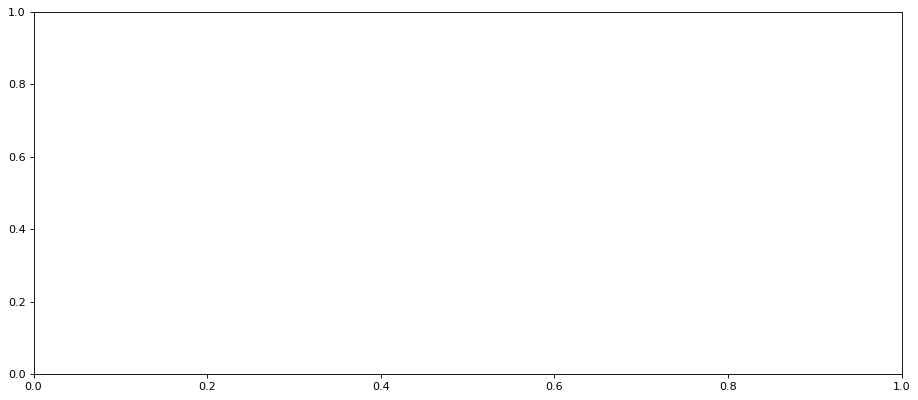

In [59]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_sample)
ax.plot(range(0,size), healthy_sample[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_sample[:,2], '-', color='blue', animated = True, linewidth=1)

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_sample)
ax.plot(range(0,size), faulty_sample[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), faulty_sample[:,0], '-', color='blue', animated = True, linewidth=1)

TypeError: '(slice(None, 500, None), 0)' is an invalid key

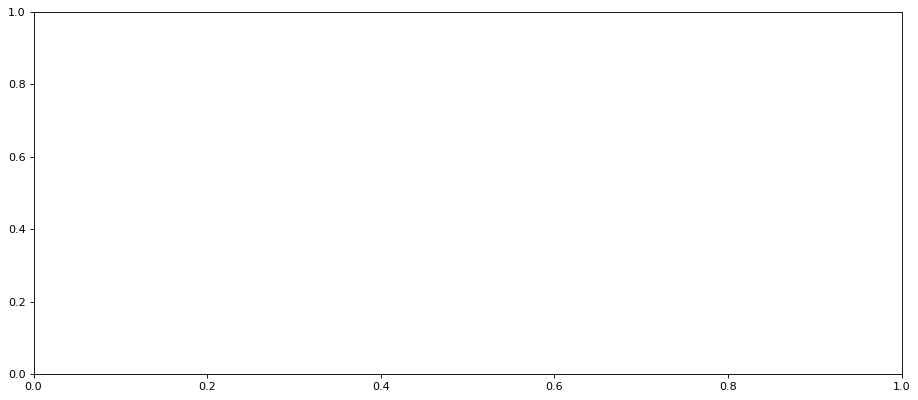

In [60]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), healthy_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), healthy_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), faulty_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), faulty_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

In [17]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [18]:
timesteps = 100
dim = 2
lossHistory = LossHistory()
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    model.fit(data, data, epochs=20, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[lossHistory])

def score(data):
    yhat =  model.predict(data)
    return yhat

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [18]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.compat.v1.Session(config=K.tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

In [19]:
def create_trimmed_recording(df,file_id):
    recording = get_recording(df,file_id) 
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return recording_trimmed

In [20]:
#pd.unique()
#df_healthy.drop(0,1).drop(2,1).drop(3,1)
pd.unique(df_healthy.iloc[:,1])

array([-0.039, -0.017, -0.098, -0.161, -0.027,  0.012, -0.061, -0.12 ,
       -0.088, -0.081, -0.068, -0.125, -0.078, -0.046, -0.11 , -0.073,
       -0.129, -0.09 , -0.122, -0.056, -0.095, -0.159, -0.093, -0.01 ,
       -0.054, -0.186, -0.132, -0.198, -0.151, -0.127, -0.413, -0.251,
        0.02 , -0.022, -0.134, -0.144, -0.112, -0.188, -0.005,  0.186,
       -0.115, -0.2  , -0.176, -0.042,  0.017, -0.173, -0.002, -0.063,
        0.029,  0.066, -0.085,  0.063, -0.071, -0.312, -0.164, -0.034,
       -0.491, -0.037,  0.188, -0.137, -0.142, -0.181, -0.049, -0.066,
       -0.212, -0.103, -0.308, -0.239, -0.117, -0.107, -0.149,  0.034,
        0.042, -0.156, -0.205, -0.083, -0.168, -0.029, -0.154, -0.288,
       -0.283, -0.032, -0.044,  0.007, -0.059, -0.076, -0.1  , -0.303,
        0.105,  0.083,  0.088, -0.105, -0.171, -0.178,  0.049, -0.166,
       -0.139, -0.225, -0.051, -0.02 , -0.146,  0.051,  0.002, -0.217,
       -0.007, -0.024, -0.183,  0.01 , -0.269,  0.027, -0.22 , -0.227,
      

In [40]:
file_ids = pd.unique(df_healthy.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy,file_id)
    print("Staring training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
healthy_losses = lossHistory.losses

KeyError: 0

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

In [ ]:
#file_ids = spark.sql('select distinct _c1 from df_healhty').rdd.map(lambda row : row._c1).collect()
start = time.time()
for file_id in [105]:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Staring training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses

In [ ]:
file_ids = pd.unique(df_faulty.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Staring training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses+faulty_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses+faulty_losses, '-', color='blue', animated = True, linewidth=1)